In [11]:
from __future__ import division, absolute_import, print_function
%load_ext autoreload
%autoreload 2

import os 
print(os.getcwd()) 
    
#import hepran
#import hepran.bzipscore as bz
#import hepran.bcipa as bc
#import hepran.utils as u
#import hepran.registers as r
#import hepran.agadir as ag

import pandas as pd
import numpy as np
import seaborn as sns
    
%matplotlib inline

import matplotlib as mpl
import matplotlib.pylab as plt

import sklearn as sk


CCO = os.environ.get("CCO",r"C:\Projekti_KI\ortoCC\CoiledCoilOrtho")

from score_utils import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
d:\data\ortoCC\fine_tune_scoring_function


In [2]:
from interactive_set_plot import *

import bokeh
import bokeh.plotting as bp
from bokeh.models import HoverTool
from IPython.core.display import display, HTML
import hepran
bp.output_notebook()

Loading BokehJS ...

In [3]:
df = pd.read_excel('data/round0_fiting.xlsx',index_col=[0,1])

In [4]:
df.columns

Index([u'seq1', u'seq2', u'Tm', u'on_target', u'avg_HP1', u'avg_HP2',
       u'avg_HP_12', u'HP1', u'HP2', u'HP_12', u'nterm_c_NN', u'nterm_c_IN',
       u'nterm_c_II', u'cterm_c_NN', u'cterm_c_IN', u'cterm_c_II', u'c_NN',
       u'c_IN', u'c_II', u'es_EE', u'es_EK', u'es_KK', u'interface_charge1',
       u'interface_charge2', u'interface_repulsion', u'cv_NN', u'cv_II',
       u'cv_NI', u'cv_IN', u'esv_KK', u'esv_EE', u'esv_EK', u'esv_KE',
       u'cvt_NNI', u'cvt_IIN', u'cvt_NNN', u'cvt_NIN', u'cvt_INN', u'cvt_III',
       u'cvt_INI', u'cvt_NII', u'esvt_EKK', u'esvt_EEK', u'esvt_EEE',
       u'esvt_EKE', u'esvt_KEE', u'esvt_KKK', u'esvt_KKE', u'esvt_KEK'],
      dtype='object')

In [5]:
basic = 'c_NN c_IN c_II es_EE es_EK es_KK'.split()
nterm_core = 'nterm_c_NN nterm_c_IN nterm_c_II'.split()
cterm_core = 'cterm_c_NN cterm_c_IN cterm_c_II'.split()
core_ends = nterm_core + cterm_core 

core_vertical = 'cv_NN cv_II cv_NI cv_IN'.split()
es_vertical = 'esv_KK esv_EE esv_EK esv_KE'.split()

core_t_vertical = 'cvt_INI cvt_IIN cvt_NII cvt_NNI cvt_NNN cvt_NIN cvt_INN cvt_III'.split()
es_t_vertical = 'esvt_EKK esvt_EEK esvt_EEE esvt_EKE esvt_KEE esvt_KKK esvt_KKE esvt_KEK'.split()
interface_rep = ['interface_repulsion']

fit_fields_dic = {
    "basic": basic,
    "basic_ends": basic + core_ends,
    "basic_rep": basic + interface_rep,
    "basic_ends_rep": basic + core_ends+interface_rep,
}


In [6]:
def set_weights(name, df):
    
    df['weights'] = 1
    if name == "W10LH":
        df['weights'] = 1
        df.loc[df.Tm < 10, 'weights'] = 10
        df.loc[df.Tm > 55, 'weights'] = 10
        df.loc[df.on_target, 'weights'] = 10
    if name == "W10":
        df.loc[df.on_target, 'weights'] = 10
    if name == "W10L":
        df['weights'] = 1
        df.loc[df.Tm < 15, 'weights'] = 10
        df.loc[df.on_target, 'weights'] = 10
    

172
R2:  0.7888840155249138
RMSE all:  13.763113720139264
RMSE >25:  14.185556310560262
RMSE on_target:  6.924867820336269


,feature,coef
0,c_NN,3.359381
1,c_IN,-1.679690
2,c_II,3.359381
3,es_EE,-3.276771
4,es_EK,3.053762
5,es_KK,-1.180565
6,interface_repulsion,-0.356290
7,cv_NN,-1.884486
8,cv_II,2.307046
9,cv_NI,2.638729


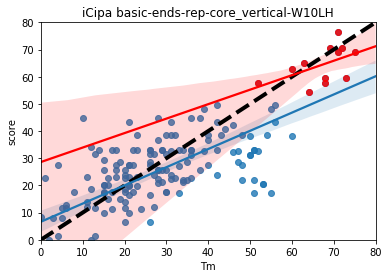

In [14]:
import sklearn
from sklearn import linear_model
from sklearn.externals import joblib

#fit_type = "basic-ends-rep"
#fit_fields = basic + interface_rep 



fit_type = "basic-ends-rep-core_vertical"
fit_fields = basic + interface_rep + core_vertical 


fit_type = "basic-ends-rep-nter_core-vertical_all"
fit_fields = basic + interface_rep + nterm_core + core_t_vertical + es_t_vertical

fit_type = "basic-ends-rep-core_t_vertical"
fit_fields = basic + interface_rep +  core_t_vertical

#BEST
fit_type = "basic-ends-rep-nter_core-core_vertical"
fit_fields = basic + interface_rep + nterm_core + core_vertical


fit_type = "basic-ends-rep-core_vertical"
fit_fields = basic + interface_rep + core_vertical


weight_string="W10LH"

set_weights(weight_string, df)
if weight_string:
    fit_type += "-" + weight_string

Q = df.query('(Tm > -15)')
print(len(Q))
lm, R2 = make_model('Tm', fit_fields, Q)


df['score'] = lm.predict(df[fit_fields])
df['pos'] = 0

joblib.dump(lm, 'models/{fit_type}.model'.format(**locals())) 
df.to_excel('data/mason_both.iCipa_{fit_type}.score.xlsx'.format(**locals()))


mpl_plot_fit(fit_type, df)
print("R2: ", R2)
print_RMSE(df)
get_model_features(lm, fit_fields)

In [248]:
df = df.apply(get_formated_seq, axis=1)
df['IDs']=df.index
bp.show(draw_scatter_interactive('Tm','score',df, y_range=(0,80),                                
                                 title=fit_type, save_to_file=False))

(0, 80)


In [383]:
#make the alignemtns 
LEN=len('EIAALEAENAALEYKNAALKAKIAALKG')
seqs_00 = df['seq1 seq2 Tm on_target pos'.split()].reset_index()
seqs_00.rename(columns={'pos': 'old_pos'}, inplace=True)
seqs_00['pos'] = 0
seqs_00['len'] = LEN

seqs_p07 = df['seq1 seq2 Tm on_target pos'.split()].reset_index()
seqs_p07.rename(columns={'pos': 'old_pos'}, inplace=True)
seqs_p07['pos'] = 7
seqs_p07['seq2'] = '-------'+seqs_p07.seq2.str[:-7]
seqs_p07['len'] = LEN -7

seqs_m07 = df['seq1 seq2 Tm on_target pos'.split()].reset_index()
seqs_m07.rename(columns={'pos': 'old_pos'}, inplace=True)
seqs_m07['pos'] = -7
seqs_m07['seq2'] = seqs_m07.seq2.str[7:]+'-------'
seqs_m07['len'] = LEN -7

#merge all to
seqs = pd.concat([seqs_00, seqs_p07, seqs_m07], ignore_index=True)

In [384]:
%%time
seqs = seqs.apply(get_CC_features, axis=1)

Wall time: 9.39 s


In [385]:
%%time
seqs['score'] = lm.predict(seqs[fit_fields])

Wall time: 1 ms


In [386]:
idx = seqs.groupby("ID1 ID2".split())['score'].idxmax()

In [387]:
best = seqs.loc[idx]

In [388]:
best.set_index("ID1 ID2".split(), inplace=True)

In [389]:
best = best.apply(get_formated_seq, axis=1)
best['IDs'] = best.index

p = draw_scatter_interactive('Tm','score', best, y_range=(0,80),                                
                 title=fit_type+'-aligned', save_to_file=False, tooltips=tooltips+[('pos', '@pos{safe}')])

moved = best[best.pos != best.old_pos]
p.circle('Tm', 'score', fill_alpha=1, size=8, source=moved)
bp.show(p)
print_RMSE(best)
get_model_features(lm, fit_fields)

(0, 80)


RMSE all:  10.690783159356187
RMSE >25:  12.07692636585692
RMSE on_target:  5.765482550521651


,feature,coef
0,c_NN,-2.564562
1,c_IN,-0.784583
2,c_II,22.967702
3,es_EE,-2.525667
4,es_EK,4.378259
5,es_KK,-0.513437
6,interface_repulsion,-0.308534
7,cv_NN,1.515839
8,cv_II,2.794905
9,cv_NI,3.462701


In [391]:
%%time
best = best.apply(get_CC_features, axis=1)

Wall time: 145 ms


R2:  0.6492286029874773
RMSE all:  10.667504751055102
RMSE >25:  12.066241627261709
RMSE on_target:  5.83972243500105


,feature,coef
0,c_NN,-2.441599
1,c_IN,0.035045
2,c_II,23.686558
3,es_EE,-2.297826
4,es_EK,4.542361
5,es_KK,-0.237315
6,interface_repulsion,-0.326204
7,cv_NN,1.658795
8,cv_II,3.369115
9,cv_NI,3.724164


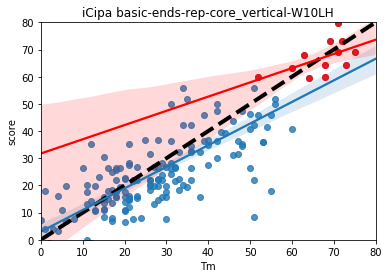

In [395]:
set_weights(weight_string, best)
lm = make_model('Tm', fit_fields, best)
best['score'] = lm.predict(best[fit_fields])
best = best.apply(get_formated_seq, axis=1)
best['IDs'] = best.index

##draw best
plt.plot([0,80], [0,80], 'k--', lw=4)
plt.title('iCipa '+fit_type)
plt.ylim([0,80])
plt.xlim([0,80])

print("R2: ",lm.score(X,Y, W))
print_RMSE(best)
sns.regplot(x='Tm', y='score', fit_reg=True, data=best)
sns.regplot(x='Tm', y='score', fit_reg=True, data=best.query('on_target'), color='red')
get_model_features(lm, fit_fields)

In [393]:
p = draw_scatter_interactive('Tm','score', best, y_range=(0,80),                                
                 title=fit_type+'-aligned', save_to_file=False, tooltips=tooltips+[('pos', '@pos{safe}')])

moved = best[best.pos != best.old_pos]
bp.show(p)
get_model_features(lm, fit_fields)
print("R2: ",lm.score(X,Y, W))
print_RMSE(df)

(0, 80)


R2:  0.6492286029874773
RMSE all:  13.763113720139264
RMSE >25:  14.185556310560262
RMSE on_target:  6.924867820336269
